In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def GenerateData(n):
    """
    生成函数 y = sin(πx) 在区间[-1, 1]的等距采样数据，数据规模为n，并为因变量加上服从标准正态分布的噪声
    """
    
    x = np.arange(-1, 1, 2 / n)[:n]
    
    Y = np.sin(np.pi * x)
    Y += np.random.normal(0, 1, n)
    
    return x.reshape((1, n)), Y.reshape((1, n))

In [3]:
def GenerateX(x, m):
    """
        将自变量x扩展为(m + 1) * n的矩阵X，X的第i行表示x^i
    """
    X = np.ones((1, x.shape[1]))
    temp = x.copy()
    
    for _ in range(m):
        X = np.vstack((temp, X))
        temp *= x
    
    return X

In [4]:
def AnalyticalSolution(X, Y, l=0.1):
    """
        返回带正则项与不带正则项的解析解
        不带正则项的解析解公式为Y(X^T)((XX^T)^(-1))
        带正则项的解析解公式为Y(X^T)((XX^T - lambda * E)^(-1))
    """
    temp = Y.dot(X.T)
    W = temp.dot(np.linalg.inv(X.dot(X.T)))
    W_rule = 2 * temp.dot(np.linalg.inv(2 * X.dot(X.T) - l * np.eye(X.shape[0])))
    
    return W, W_rule

In [5]:
def GD(X, Y, l=0.1, lr=0.01):
    """
        梯度下降法
    """
    #初始化参数
    W = np.random.rand(1, X.shape[0])
    W_rule = np.random.rand(1, X.shape[0])
    #设置梯度变化量阈值
    threshold = 1e-9
    #设置退出循环的条件
    continues = [True, True]
    count = 0
    
    while (continues[0] or continues[1]) and count < 10000:
        #计算不带正则项的梯度
        dW = 2 * (W.dot(X) -Y).dot(X.T)
        
        #更新并设置不带正则项相关参数
        if continues[0]:
            #更新不带正则项的参数
            W -= lr * dW / X.shape[1]
            #更新循环退出条件
            continues[0] = np.average(dW) > threshold
        
        #更新并设置带正则项相关参数
        if continues[1]:
            #计算梯度
            dW_rule = dW + l * W_rule
            #更新参数
            W_rule -= lr * dW_rule / X.shape[1]
            #设置循环退出条件
            continues[1] = np.average(dW_rule) > threshold
        
        count += 1
    
    return W, W_rule

In [6]:
def CG(X, Y):
    """
        共轭梯度法
    """
    #初始化参数与设置阈值
    W = np.zeros((X.shape[0], 1))
    threshold = 1e-9
    
    A = X.dot(X.T)
    b = X.dot(Y.T)
    
    d0 = np.zeros((X.shape[0], 1))
    r0 = -b
    
    #迭代，当迭代次数大于等于n或残差大于阈值时退出
    for _ in range(X.shape[1]):
        #计算残差
        r = A.dot(W) - b
        #判断退出条件
        if(r.T.dot(r) < threshold):
            break
        
        #计算梯度方向
        d = -r + r.T.dot(r) / r0.T.dot(r0) * d0
        #计算步长
        alpha = - d.T.dot(r) / d.T.dot(A).dot(d)
        
        #更新参数
        W += alpha * d
        d0 = d
        r0 = r
    
    return W.T

In [12]:
N = [10, 50, 100, 500]
M = [2, 4, 7, 9]
L = [0, 0.05, 0.1, 0.5, 1]
lr = 0.01
t = np.arange(-1, 1, 0.05).reshape((1, 40))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

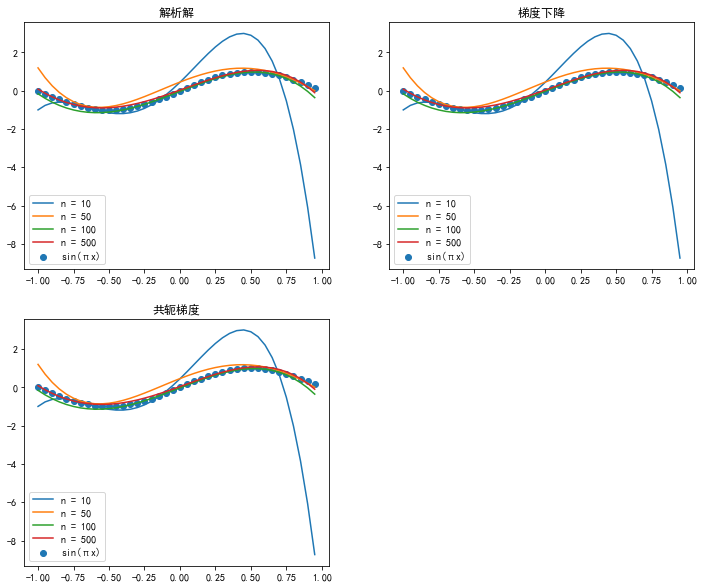

In [18]:
#数据量
plt.figure(figsize=(12, 10))
titles = ['解析解', '梯度下降', '共轭梯度']
T = GenerateX(t, 4)
W = [[None] * len(N)] * 3
for i in range(len(N)):
    x, Y = GenerateData(N[i])
    X = GenerateX(x, 4)
    W[0][i], _ = AnalyticalSolution(X, Y, l=0.05)
    W[1][i], _ = GD(X, Y, l=0.05, lr=0.01)
    W[2][i] = CG(X, Y)
    
for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_title(titles[i])
    ax.scatter(t, np.sin(np.pi * t))
    for j in range(len(N)):
        plt.plot(list(t)[0], list(W[i][j].dot(T))[0])
    labels = ['n = ' + str(N[i]) for i in range(len(N))] + ['sin(πx)']
    plt.legend(labels=labels)
plt.savefig('数据量.png')
plt.show()

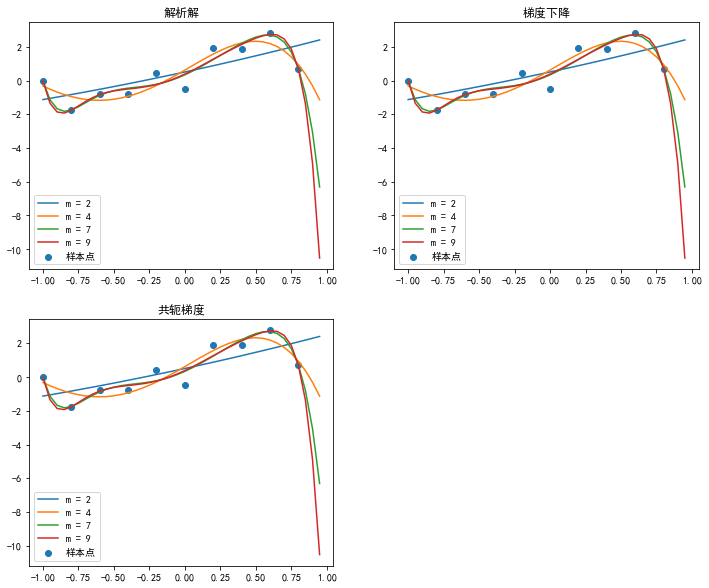

In [47]:
#阶数
plt.figure(figsize=(12, 10))
titles = ['解析解', '梯度下降', '共轭梯度']
W = [[None] * len(M)] * 3
x, Y = GenerateData(10)
for i in range(len(M)):
    temp = [None] * 3
    X = GenerateX(x, M[i])
    T = GenerateX(t, M[i])
    temp[0], _ = AnalyticalSolution(X, Y, l=0.05)
    temp[1], _ = GD(X, Y, l=0.05, lr=0.01)
    temp[2] = CG(X, Y)
    for j in range(3):
        W[j][i] = temp[j].dot(T)

for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_title(titles[i])
    ax.scatter(x, Y)
    for j in range(len(N)):
        plt.plot(list(t)[0], list(W[i][j])[0])
    labels = ['m = ' + str(M[i]) for i in range(len(M))] + ['样本点']
    plt.legend(labels=labels)
plt.savefig('阶数.png')
plt.show()

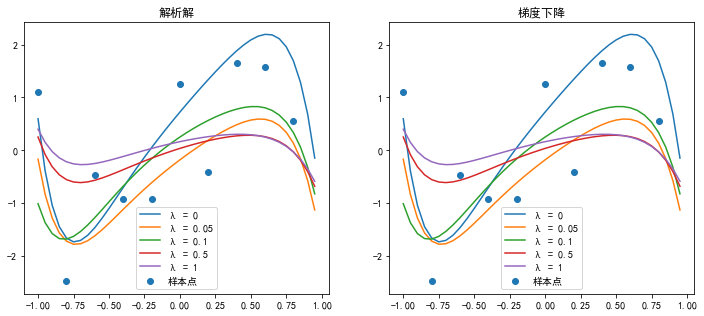

In [42]:
#正则项系数
plt.figure(figsize=(12, 5))
titles = ['解析解', '梯度下降']
x, Y = GenerateData(10)
X = GenerateX(x, 7)
T = GenerateX(t, 7)
W = [[None] * len(L)] * 2
for i in range(len(L)):
    _, W[0][i] = AnalyticalSolution(X, Y, l=L[i])
    _, W[1][i] = GD(X, Y, l=L[i], lr=0.01)
for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    ax.set_title(titles[i])
    ax.scatter(x, Y)
    for j in range(len(L)):
        plt.plot(list(t)[0], list(W[i][j].dot(T))[0])
    labels = ['λ = ' + str(L[i]) for i in range(len(L))] + ['样本点']
    plt.legend(labels=labels)
plt.savefig('正则项系数.png')
plt.show()

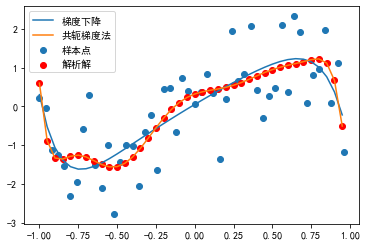

In [46]:
#对比
x, Y = GenerateData(50)
X = GenerateX(x, 9)
T = GenerateX(t, 9)
W1, _ = AnalyticalSolution(X, Y, l=0.05)
W2, _ = GD(X, Y, l=0.05, lr=0.01)
W3 = CG(X, Y)
plt.scatter(x, Y)
plt.scatter(list(t)[0], list(W1.dot(T))[0], color='red')
plt.plot(list(t)[0], list(W2.dot(T))[0])
plt.plot(list(t)[0], list(W3.dot(T))[0])
plt.legend(['梯度下降', '共轭梯度法', '样本点', '解析解'])
plt.savefig('对比.png')
plt.show()